Found 4044 images belonging to 2 classes.
Found 1010 images belonging to 2 classes.
Epoch 1/10


C:\Users\zidan\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


127/127 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.4918 - loss: 0.9113 - val_accuracy: 0.5020 - val_loss: 0.7277
Epoch 2/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step - accuracy: 0.4933 - loss: 0.8011 - val_accuracy: 0.4891 - val_loss: 0.7096
Epoch 3/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 128s 996ms/step - accuracy: 0.5056 - loss: 0.7507 - val_accuracy: 0.4901 - val_loss: 0.7035
Epoch 4/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.4915 - loss: 0.7341 - val_accuracy: 0.4931 - val_loss: 0.6992
Epoch 5/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - accuracy: 0.4862 - loss: 0.7190 - val_accuracy: 0.4901 - val_loss: 0.6956
Epoch 6/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.4868 - loss: 0.7089 - val_accuracy: 0.5059 - val_loss: 0.6954
Epoch 7/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - accuracy: 0.4893 - loss: 0.7096 - val_accuracy: 0.5109 - val_loss: 0.6949
Epoch 8/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - accuracy: 0.5117 - loss: 0.6972 - val_accuracy: 0.

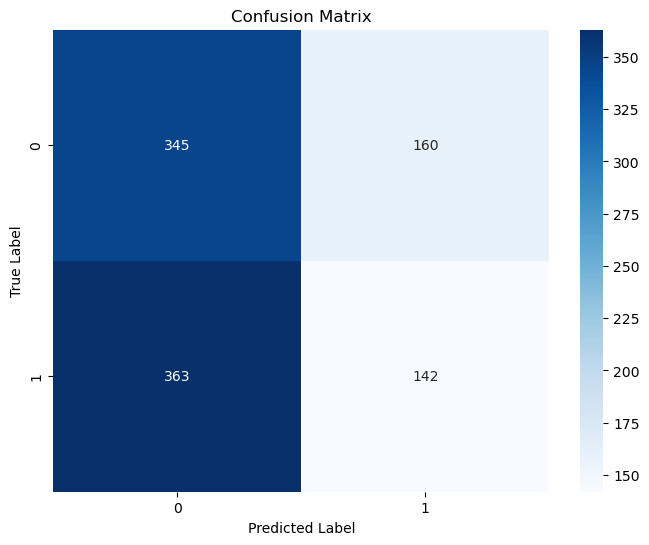

              precision    recall  f1-score   support

       train       0.49      0.68      0.57       505
  validation       0.47      0.28      0.35       505

    accuracy                           0.48      1010
   macro avg       0.48      0.48      0.46      1010
weighted avg       0.48      0.48      0.46      1010



In [1]:
import os
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from PyQt5.QtWidgets import QApplication, QFileDialog
import sys

# Dataset Path
dataset_path = r"C:\Users\zidan\Desktop\Coding\PYTHON\garbage_classification"
if not os.path.exists(dataset_path):
    raise ValueError("Dataset path tidak ditemukan!")

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest',
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    dataset_path, target_size=(224, 224), batch_size=32, class_mode='categorical', subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    dataset_path, target_size=(224, 224), batch_size=32, class_mode='categorical', subset='validation'
)

class_names = list(train_generator.class_indices.keys())

# Load Pre-trained Model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze model awalnya

# Tambahkan lapisan baru
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(len(class_names), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Compile Model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Training Model
model.fit(train_generator, epochs=10, validation_data=validation_generator)

# Unfreeze beberapa layer terakhir untuk fine-tuning
for layer in base_model.layers[-20:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tuning
model.fit(train_generator, epochs=5, validation_data=validation_generator)

# Evaluasi Model
y_true = validation_generator.classes
y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_true, y_pred_classes), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_true, y_pred_classes, target_names=class_names))



In [2]:
# Fungsi untuk Test-Time Augmentation (TTA)
def tta_predict(image, model, n_augmentations=5):
    preds = []
    for _ in range(n_augmentations):
        aug_image = cv2.flip(image, flipCode=np.random.choice([-1, 0, 1]))
        resized_image = cv2.resize(aug_image, (224, 224))
        normalized_image = resized_image.astype("float") / 255.0
        input_image = np.expand_dims(normalized_image, axis=0)
        preds.append(model.predict(input_image)[0])
    return np.mean(preds, axis=0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 902ms/step


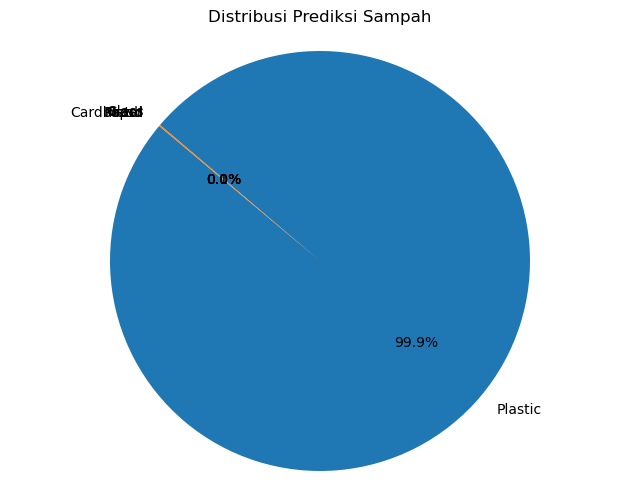

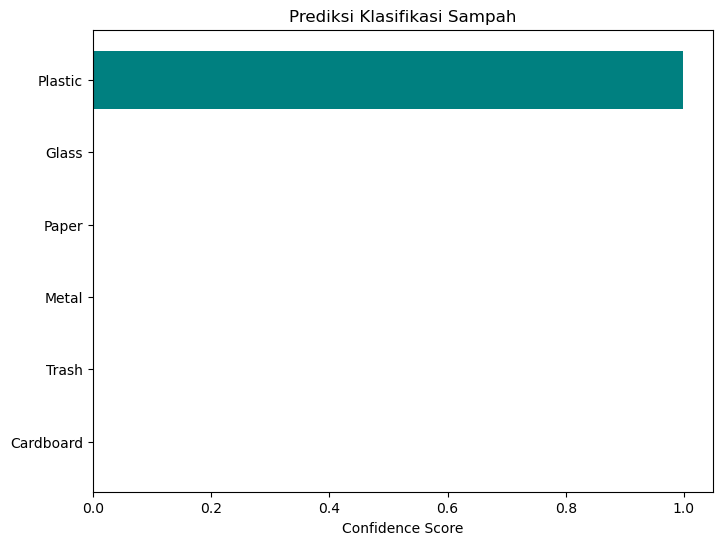

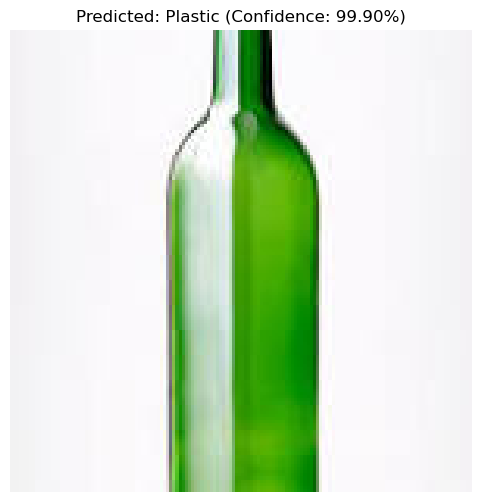

Predicted Class: Plastic
Confidence Score: 99.90%
Detail Prediksi:  {'Cardboard': 4.306926e-15, 'Glass': 0.0010444565, 'Metal': 2.7473262e-11, 'Paper': 2.6466837e-10, 'Plastic': 0.9989555, 'Trash': 1.2081831e-11}


In [8]:
from tensorflow.keras.models import load_model

# 🔹 Muat Model yang Sudah Dilatih
model = load_model('best_model.keras')

# 🔹 Pastikan Urutan Label Sesuai dengan Dataset
class_names = ["Cardboard", "Glass", "Metal", "Paper", "Plastic", "Trash"]

# 📌 Fungsi Preprocessing Gambar (Wajib Sama dengan Training)
def preprocess_image(image):
    resized_image = cv2.resize(image, (224, 224))  # Resize ke ukuran input model
    normalized_image = resized_image.astype("float32") / 255.0  # Normalisasi
    input_image = np.expand_dims(normalized_image, axis=0)  # Tambahkan batch dimension
    return input_image

# 📌 Fungsi Prediksi Sampah
def detect_and_classify_trash(image):
    input_image = preprocess_image(image)  # Preprocessing gambar sebelum prediksi
    
    predictions = model.predict(input_image)  # Prediksi dari model
    predicted_class_index = np.argmax(predictions)  # Ambil kelas dengan confidence tertinggi
    
    # 🔹 Mapping hasil prediksi ke label kelas
    class_predictions = {class_names[i]: predictions[0][i] for i in range(len(class_names))}
    sorted_predictions = sorted(class_predictions.items(), key=lambda x: x[1], reverse=True)
    
    labels = [class_name for class_name, _ in sorted_predictions]
    scores = [score for _, score in sorted_predictions]

    # 🔹 Pie Chart
    plt.figure(figsize=(8, 6))
    plt.pie(scores, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.axis('equal')
    plt.title('Distribusi Prediksi Sampah')
    plt.show()

    # 🔹 Bar Chart
    plt.figure(figsize=(8, 6))
    plt.barh(labels[::-1], scores[::-1], color='teal')
    plt.xlabel('Confidence Score')
    plt.title('Prediksi Klasifikasi Sampah')
    plt.show()

    # 🔹 Tampilkan Gambar
    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f'Predicted: {labels[0]} (Confidence: {scores[0]*100:.2f}%)')  # ✅ Perbaikan di sini
    plt.axis('off')
    plt.show()

    print(f"Predicted Class: {labels[0]}")
    print(f"Confidence Score: {scores[0]*100:.2f}%")
    print("Detail Prediksi: ", class_predictions)

# 📌 Fungsi Pilih Gambar
def select_image():
    app = QApplication(sys.argv)
    file_path, _ = QFileDialog.getOpenFileName(None, "Pilih Gambar", "", "Image Files (*.png;*.jpg;*.jpeg;*.bmp)")

    if file_path:
        try:
            image = cv2.imread(file_path)
            if image is None:
                raise ValueError("Gambar tidak dapat dibaca. Pastikan format file benar.")
            detect_and_classify_trash(image)
        except Exception as e:
            print(f"Error: {e}")
    
    app.quit()

# 🔹 Jalankan pemilihan gambar
if __name__ == "__main__":
    select_image()